In [1]:
# Import libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Data Augmentation
Lets add augmented data to our Dataset Before proceeding lets understand some of the datasets

## Augmentation methods

In [65]:
"""
    Adding White Noise.
"""

def noise(data):
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    

In [66]:
"""
    Random Shifting.
"""

def shift(data):
    s_range = int(np.random.uniform(low=-5, high = 5)*1000)  #default at 500
    return np.roll(data, s_range)

In [67]:
"""
    Streching the Sound. Note that this expands the dataset slightly
"""

def stretch(data, rate=0.8):
    data = librosa.effects.time_stretch(data, rate)
    return data

In [68]:
"""
    Pitch Tuning.
"""

def pitch(data, sample_rate):
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data

In [69]:
"""
    Random Value Change.
"""

def dyn_change(data):
    dyn_change = np.random.uniform(low=-0.5 ,high=3)  # default low = 1.5, high = 3
    return (data * dyn_change)

In [70]:
"""
    peed and Pitch Tuning.
"""

def speedNpitch(data):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

In [71]:
os.listdir('Data/genres_original')

['metal',
 'blues',
 'country',
 'reggae',
 'rock',
 'hiphop',
 'classical',
 'pop',
 'disco',
 'jazz']

In [24]:
Class = ['country',
 'jazz',
 'classical',
 'pop',
 'blues',
 'hiphop',
 'disco',
 'reggae',
 'rock',
 'metal']

In [25]:
Class.sort()

In [26]:
Class

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

# Load the dataset

In [75]:
ref = pd.DataFrame()

labels_list =[]
path_list = []

for i in Class:
    filepath = os.path.join('Data/genres_original',i)
    label  = i
    for audio_name in os.listdir(filepath):
        audiopath = os.path.join(filepath , audio_name)
        labels_list.append(label)
        path_list.append(audiopath)
    

In [76]:
ref["labels"] = labels_list
ref["path"] = path_list

In [77]:
ref.head(200)

,labels,path
0,blues,Data/genres_original/blues/blues.00011.wav
1,blues,Data/genres_original/blues/blues.00038.wav
2,blues,Data/genres_original/blues/blues.00045.wav
3,blues,Data/genres_original/blues/blues.00076.wav
4,blues,Data/genres_original/blues/blues.00012.wav
...,...,...
195,classical,Data/genres_original/classical/classical.00000...
196,classical,Data/genres_original/classical/classical.00020...
197,classical,Data/genres_original/classical/classical.00013...
198,classical,Data/genres_original/classical/classical.00052...


In [78]:
ref.shape

(1000, 2)

In [79]:
ref["path"][0]

'Data/genres_original/blues/blues.00011.wav'

# Feature Extraction

In [80]:
from tqdm import tqdm

In [81]:
X, sample_rate = librosa.load(ref["path"][0], res_type='kaiser_fast')


sr = sample_rate
    
melspectogram = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate),axis=1) # (128,)
# rmse = librosa.feature.rms(y=X)[0]

S = librosa.feature.melspectrogram(y=X, sr=sr, power=1)
pcen_S = np.mean(librosa.pcen(S * (2**31)),axis=1)  #(128,)

chroma_stft = np.mean(librosa.feature.chroma_stft(y=X, sr=sr), axis=1)

print("melspectogram : ",melspectogram.shape)
# print("rmse : ",rmse.shape)
print("pcen_S : ",pcen_S.shape)
print("chroma_stft : ",chroma_stft.shape)

melspectogram :  (128,)
pcen_S :  (128,)
chroma_stft :  (12,)


In [82]:
def features(X, sample_rate) :
    sr = sample_rate
    
    melspectogram = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate),axis=1) # (128,)
    
    S = librosa.feature.melspectrogram(y=X, sr=sr, power=1)
    pcen_S = np.mean(librosa.pcen(S * (2**31)),axis=1)  #(128,)
    
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=X, sr=sr), axis=1)
    
    combined_features = np.append(melspectogram, pcen_S )
    combined_features = np.append(combined_features, chroma_stft )
    
    return combined_features

In [84]:
df = pd.DataFrame(columns=['feature', "music_label"])

# loop feature extraction over the entire dataset
counter=0
for index,path in tqdm(enumerate(ref.path)):
    try:
        X, sample_rate = librosa.load(path, res_type='kaiser_fast')
        
        #original data
        data = features(X,sample_rate)
        df.loc[counter] = [data,ref.labels[index]]
        counter=counter+1  
        
        # add noise
        noised_data = noise(X) ;
        data = features(noised_data, sample_rate)
        df.loc[counter] = [data,ref.labels[index]]
        counter=counter+1  
        
        #shift data
        shifted_data = shift(X)
        data = features(shifted_data,sample_rate)
        df.loc[counter] = [data,ref.labels[index]]
        counter=counter+1  
        
        #stretch data
        stretched_data = stretch(X)
        data = features(stretched_data, sample_rate)
        df.loc[counter] = [data,ref.labels[index]]
        counter=counter+1 
        
        # pitch
        pitched_data = pitch(X,sample_rate)
        data = features(pitched_data, sample_rate)
        df.loc[counter] = [data,ref.labels[index]]
        counter=counter+1
        
        #random change 
        random_changed_data = dyn_change(X)
        data = features(random_changed_data, sample_rate)
        df.loc[counter] = [data,ref.labels[index]]
        counter=counter+1
        
        #speed and Pitch Tuning.
        newX = speedNpitch(X)
        data = features(newX, sample_rate)
        df.loc[counter] = [data,ref.labels[index]]
        counter=counter+1
                
    except :
        pass

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

1000it [45:32,  2.73s/it]

6993


,feature,music_label
0,"[0.12185397744178772, 17.404531478881836, 77.7...",blues
1,"[0.140749229775818, 17.423782033450017, 77.824...",blues
2,"[0.12020295858383179, 17.398462295532227, 77.8...",blues
3,"[0.0660770907998085, 10.971394538879395, 43.49...",blues
4,"[0.015618966151903333, 5.368681670788682, 26.3...",blues


In [85]:
import pickle
pickle.dump(df, open("augmented_data_without_mfccs_rmse", "wb"))

In [2]:
import pickle
df = pickle.load(open("augmented_data_without_mfccs_rmse", "rb"))

In [3]:
final_df = pd.DataFrame()
final_df = pd.concat([final_df,pd.DataFrame(df["music_label"]),pd.DataFrame(df['feature'].values.tolist())],axis=1)


In [4]:
final_df.head()

,music_label,0,1,2,3,4,5,6,7,8,...,258,259,260,261,262,263,264,265,266,267
0,blues,0.121854,17.404531,77.799339,26.088753,4.421338,6.066106,9.539007,12.756526,5.626464,...,0.295843,0.396180,0.648138,0.569606,0.362394,0.349990,0.345085,0.351322,0.277726,0.321803
1,blues,0.140749,17.423782,77.824126,26.121254,4.430809,6.072560,9.546519,12.804598,5.650619,...,0.404198,0.497750,0.694077,0.585658,0.411690,0.412725,0.413598,0.415967,0.365174,0.398804
2,blues,0.120203,17.398462,77.813942,26.085047,4.421679,6.065790,9.535270,12.755334,5.625061,...,0.307991,0.420271,0.661798,0.533604,0.350115,0.348200,0.346293,0.346998,0.276022,0.319821
3,blues,0.066077,10.971395,43.498329,13.242426,1.974879,2.811138,4.887968,6.820376,2.781509,...,0.306818,0.407498,0.638837,0.519588,0.341449,0.339097,0.354733,0.363631,0.286109,0.335535
4,blues,0.015619,5.368682,26.346423,14.747822,2.847890,1.931002,4.506615,5.235744,4.464450,...,0.213059,0.252576,0.389223,0.653810,0.466284,0.319354,0.347448,0.337652,0.335558,0.273403


In [5]:
# replace NA with 0
final_df=final_df.fillna(0)
print(final_df.shape)
final_df[:5]


(6993, 269)


,music_label,0,1,2,3,4,5,6,7,8,...,258,259,260,261,262,263,264,265,266,267
0,blues,0.121854,17.404531,77.799339,26.088753,4.421338,6.066106,9.539007,12.756526,5.626464,...,0.295843,0.396180,0.648138,0.569606,0.362394,0.349990,0.345085,0.351322,0.277726,0.321803
1,blues,0.140749,17.423782,77.824126,26.121254,4.430809,6.072560,9.546519,12.804598,5.650619,...,0.404198,0.497750,0.694077,0.585658,0.411690,0.412725,0.413598,0.415967,0.365174,0.398804
2,blues,0.120203,17.398462,77.813942,26.085047,4.421679,6.065790,9.535270,12.755334,5.625061,...,0.307991,0.420271,0.661798,0.533604,0.350115,0.348200,0.346293,0.346998,0.276022,0.319821
3,blues,0.066077,10.971395,43.498329,13.242426,1.974879,2.811138,4.887968,6.820376,2.781509,...,0.306818,0.407498,0.638837,0.519588,0.341449,0.339097,0.354733,0.363631,0.286109,0.335535
4,blues,0.015619,5.368682,26.346423,14.747822,2.847890,1.931002,4.506615,5.235744,4.464450,...,0.213059,0.252576,0.389223,0.653810,0.466284,0.319354,0.347448,0.337652,0.335558,0.273403


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(final_df.drop(['music_label'],axis=1)
                                                    , df.music_label
                                                    , test_size=0.2
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,258,259,260,261,262,263,264,265,266,267
3161,6.865971,240.019984,245.136522,94.511053,76.688914,10.890987,9.907224,8.570671,5.646119,4.940104,...,0.395514,0.371402,0.345541,0.445463,0.368060,0.426686,0.451794,0.386853,0.431799,0.487261
3961,0.038329,0.853959,2.763967,4.828531,2.783260,1.704199,0.655023,0.622787,0.527593,0.376057,...,0.385900,0.162766,0.218629,0.176249,0.215190,0.214077,0.152957,0.240899,0.185182,0.235429
3248,12.572579,343.948822,796.816467,538.358459,208.078857,104.755295,101.470856,52.245602,50.621944,44.129623,...,0.390627,0.474566,0.458638,0.460867,0.431108,0.410211,0.388513,0.391785,0.456031,0.432824
149,37.643291,175.614044,172.551437,91.572105,78.519562,48.407230,40.700436,52.681610,78.914215,93.744873,...,0.292011,0.476460,0.307396,0.300546,0.321262,0.337033,0.321753,0.282487,0.500763,0.286689
4667,35.166931,244.442047,266.459595,270.247772,127.812042,50.150738,22.959772,52.495190,40.248219,45.028049,...,0.576534,0.450994,0.489501,0.372266,0.375912,0.457270,0.545990,0.625782,0.481199,0.473345
3869,0.066969,0.180239,0.651562,0.574692,0.334578,0.748195,1.762686,2.795363,1.937764,2.391882,...,0.199413,0.256288,0.268117,0.212511,0.178056,0.355760,0.340738,0.268651,0.294920,0.304627
453,0.022587,0.640513,1.992635,2.067175,2.864734,2.022243,1.253996,1.889712,1.259912,2.157449,...,0.338403,0.345006,0.283877,0.413017,0.292388,0.293864,0.304520,0.324511,0.285682,0.294126
3282,4.442932,121.551949,65.589317,12.166665,8.251149,7.897643,6.370042,3.374386,2.562865,2.768436,...,0.501440,0.390008,0.378011,0.373218,0.342142,0.334268,0.395329,0.413003,0.421103,0.495779
1786,3.499032,25.494401,26.231935,18.284696,14.965359,21.213239,25.280074,25.244139,26.319473,16.404427,...,0.412077,0.408539,0.311546,0.329985,0.255256,0.356269,0.320906,0.309679,0.417340,0.255055
2716,9.475857,52.525173,24.459503,16.689140,22.578693,13.057518,2.685603,1.842606,2.181042,4.007666,...,0.436774,0.352679,0.384983,0.330324,0.419716,0.523925,0.414172,0.412719,0.388009,0.532525


In [8]:
# # Lets do data normalization
# #Here we are using z-score normalization technique
# mean = np.mean(X_train, axis=0)
# std = np.std(X_train, axis=0)

# X_train = (X_train - mean)/std
# X_test = (X_test - mean)/std

# # Check the dataset now 
# X_train[150:160]

In [9]:
from keras.utils import np_utils, to_categorical
from sklearn.preprocessing import LabelEncoder
import pickle

In [10]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Label encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'mgc_label_encoder'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(5594, 268)
['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


In [11]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(5594, 268, 1)

In [12]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint


In [18]:
model = Sequential()
model.add(Conv1D(256, 4, padding='same',input_shape=(X_train.shape[1],1))) 
# X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 4, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(4)))

model.add(Conv1D(128, 4, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv1D(128, 4, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(4)))

model.add(Conv1D(64, 4, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv1D(64, 4, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(10)) # Target class number
model.add(Activation('softmax'))

opt = keras.optimizers.Adam(lr=0.0001)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 268, 256)          1280      
_________________________________________________________________
activation_9 (Activation)    (None, 268, 256)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 268, 256)          262400    
_________________________________________________________________
batch_normalization_2 (Batch (None, 268, 256)          1024      
_________________________________________________________________
activation_10 (Activation)   (None, 268, 256)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 268, 256)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 67, 256)          

In [14]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_test, y_test))

Epoch 1/40
175/175 [==============================] - 53s 291ms/step - loss: 2.1841 - accuracy: 0.2164 - val_loss: 2.0768 - val_accuracy: 0.2766
Epoch 2/40
175/175 [==============================] - 50s 287ms/step - loss: 1.7560 - accuracy: 0.3757 - val_loss: 1.8954 - val_accuracy: 0.2995
Epoch 3/40
175/175 [==============================] - 51s 289ms/step - loss: 1.4858 - accuracy: 0.4897 - val_loss: 2.0363 - val_accuracy: 0.2009
Epoch 4/40
175/175 [==============================] - 66s 379ms/step - loss: 1.3207 - accuracy: 0.5485 - val_loss: 1.8950 - val_accuracy: 0.2588
Epoch 5/40
175/175 [==============================] - 60s 345ms/step - loss: 1.2017 - accuracy: 0.5820 - val_loss: 1.5097 - val_accuracy: 0.4711
Epoch 6/40
175/175 [==============================] - 66s 375ms/step - loss: 1.0627 - accuracy: 0.6292 - val_loss: 1.4020 - val_accuracy: 0.5490
Epoch 7/40
175/175 [==============================] - 61s 350ms/step - loss: 0.9789 - accuracy: 0.6608 - val_loss: 1.3898 - val_ac

In [15]:
model.save("MGC_Models/mgc_model_pcen_with_extra_features.h5") #(mfccs+pcen+chroma)

In [14]:
from tensorflow import keras
model = keras.models.load_model("MGC_Models/mgc_model_pcen_with_extra_features.h5")

In [15]:
score = model.evaluate(X_test, y_test, verbose=0)
score
print("Loss : {}  \nAccuracy : {} ".format(score[0], score[1]))

Loss : 0.3612132668495178  
Accuracy : 0.9020729064941406 


In [16]:
score = model.evaluate(X_test, y_test, verbose=0)
score
print("Loss : {}  \nAccuracy : {} ".format(score[0], score[1]))

Loss : 0.3612132668495178  
Accuracy : 0.9020729064941406 


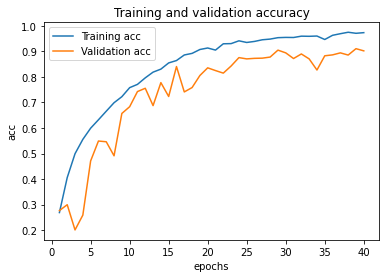

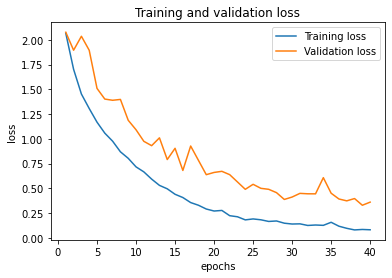

In [17]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

In [20]:
preds = model.predict(X_test)
preds=preds.argmax(axis=1)
preds

array([6, 5, 7, ..., 0, 5, 1])

In [21]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
temp_df = pd.DataFrame()
final_df = pd.concat([temp_df,finaldf],axis=1)

final_df.head()

,actualvalues,predictedvalues
0,metal,metal
1,jazz,jazz
2,pop,pop
3,classical,classical
4,jazz,jazz


In [22]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
blues,136
classical,153
country,125
disco,142
hiphop,129
jazz,151
metal,134
pop,132
reggae,131


In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

In [29]:
classes = Class
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       blues       0.96      0.86      0.91       153
   classical       0.88      0.99      0.93       136
     country       0.95      0.79      0.86       151
       disco       0.85      0.92      0.88       132
      hiphop       0.94      0.90      0.92       135
        jazz       0.89      0.93      0.91       144
       metal       0.96      0.96      0.96       134
         pop       0.92      0.86      0.89       142
      reggae       0.97      0.91      0.94       140
        rock       0.75      0.95      0.84       132

    accuracy                           0.90      1399
   macro avg       0.91      0.90      0.90      1399
weighted avg       0.91      0.90      0.90      1399



In [34]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'


0.902072909220872


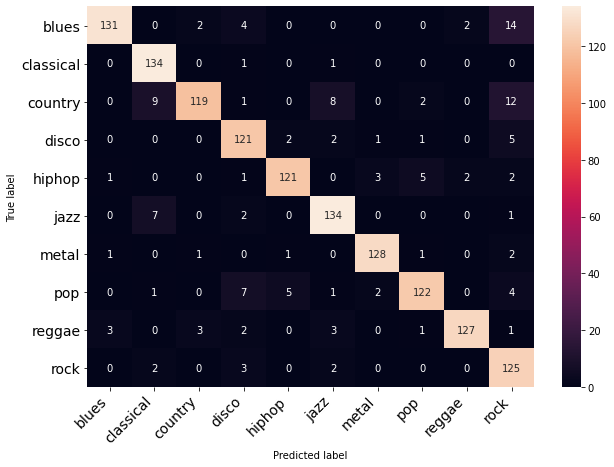

In [35]:
# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = Class)